Most of the things in this notebook has been based on the Kaggle notebook provided by [Chaitanya at here](https://www.kaggle.com/chaitanya99/recommendation-system-cf-anime/notebook). Thank you for the amazing and informative notebook! And please consider support his work by upvoting him.

In this notebook, I changed my model and some of the parts to extend on his work and also mainly to compare the training results to make sure that I'm not doing things incorrectly.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import joblib
import os



In [6]:
# df = pd.read_csv(CLEAN_ANIME_DIR)
df = pd.read_csv('animelist.csv', low_memory=False, usecols=["user_id", "anime_id", "rating"], nrows=90000000)
anime_df = pd.read_csv( 'anime.csv')
df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
# User should rate atleast 200 animies
n_ratings = df['user_id'].value_counts()

min_n_ratings = 200
df = df[df['user_id'].isin(n_ratings[n_ratings >= min_n_ratings].index)]
len(df)

79012871

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
# df.drop(columns=['watching_status', 'watched_episodes'], inplace=True)

# Preprocessing

In [10]:
user_id_to_idx = {user_id: i for i, user_id in enumerate(df.user_id.unique())}
user_idx_to_id = {idx: user_id for user_id, idx in user_id_to_idx.items()}
anime_id_to_idx = {anime_id: i for i, anime_id in enumerate(df.anime_id.unique())}
anime_idx_to_id = {idx: anime_id for anime_id, idx in anime_id_to_idx.items()}
df["user_id"] = df["user_id"].map(user_id_to_idx)
df["anime_id"] = df["anime_id"].map(anime_id_to_idx)

n_users = len(user_id_to_idx)
n_animes = len(anime_id_to_idx)

print(f"Num of users: {n_users}")
print(f"Num of animes: {n_animes}")

Num of users: 145311
Num of animes: 17562


In [11]:
# encoder_dicts = {'user_id_to_idx': user_id_to_idx,'user_idx_to_id': user_idx_to_id,
#                  'anime_id_to_idx': anime_id_to_idx, 'anime_idx_to_id': anime_idx_to_id}
# joblib.dump(encoder_dicts, 'encoder_dicts.joblib')

In [12]:
f'{len(df):,}'

'79,012,870'

In [13]:
# Shuffle
df = df.sample(frac=1, random_state=73)

X = df[['user_id', 'anime_id']].values
# scale to [0, 1]
# y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y = (df["rating"] / 10.).values

# Split
test_set_size = 1000000 #1m for test set
train_indices = len(df) - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [14]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     df.drop(columns='rating').values, df['rating'].values, 
#     test_size=0.01, random_state=42)

In [15]:
print(f'Length of train set: {len(y_train)}')
print(f'Length of test set: {len(y_test)}')

Length of train set: 78012870
Length of test set: 1000000


In [16]:
X_train.shape, X_test.shape

((78012870, 2), (1000000, 2))

In [17]:
df.nunique()

user_id     145311
anime_id     17562
rating          11
dtype: int64

In [18]:
# X_train_user, X_train_anime = (X_train[:, 0], X_train[:, 1])
# X_test_user, X_test_anime = (X_test[:, 0], X_test[:, 1])

In [19]:
# Each input is only with shape of (BS, 1)
# X_train_user.shape, X_test_anime.shape

In [21]:
# Accelerator check
import tensorflow as tf

TPU_INIT = False

# if TPU_INIT:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     !nvidia-smi
if TPU_INIT:
    try:
        GPU = False
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        TPU_INIT = False
        GPU = True
        print("Not connected to a TPU runtime. Using CPU/GPU strategy")
        tpu_strategy = tf.distribute.MirroredStrategy()
        !nvidia-smi
    
print(tf.__version__)

2.15.0


# **Model Building**

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from tensorflow_addons.optimizers import AdamW
# from tensorflow.keras.experimental import CosineDecayRestarts

In [23]:
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
# from tensorflow.keras.optimizers.schedules import PolynomialDecay

In [24]:
# testing Dot layer for dot product
x1 = Embedding(100, output_dim=50)(np.arange(100).reshape(5, 20))
x2 = Embedding(100, output_dim=50)(np.arange(50).reshape(5, 10))
dotted = Dot(axes=2)([x1, x2])
print("(BS, n_users, embedding_size)")
print(x1.shape)
print("(BS, n_animes, embedding_size)")
print(x2.shape)
print("Dot product shape:")
print(dotted.shape)

2024-04-18 15:27:00.287109: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-18 15:27:00.287169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-18 15:27:00.287183: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-18 15:27:00.287669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 15:27:00.288258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(BS, n_users, embedding_size)
(5, 20, 50)
(BS, n_animes, embedding_size)
(5, 10, 50)
Dot product shape:
(5, 20, 10)


In [25]:
n_users, n_animes

(145311, 17562)

In [26]:
# X_train_user[0], X_train_anime[0], y_train[0]
X_train[0][0], X_train[0][0], y_train[0]

(130299, 130299, 0.8)

In [27]:
# each of them has a shape of 1
df[(df.user_id == 64118) & (df.anime_id == 4551)]

,user_id,anime_id,rating


# Config and Model

In [30]:
%%time
import joblib

ENCODER_PATH = 'encoder_dicts.joblib'
encoders_dict = joblib.load(ENCODER_PATH)
print(encoders_dict.keys())

anime_id_to_idx = encoders_dict['anime_id_to_idx']
anime_idx_to_id = encoders_dict['anime_idx_to_id']
user_id_to_idx = encoders_dict['user_id_to_idx']
user_idx_to_id = encoders_dict['user_idx_to_id']

n_users, n_animes = len(user_id_to_idx), len(anime_id_to_idx)
n_users, n_animes

dict_keys(['user_id_to_idx', 'user_idx_to_id', 'anime_id_to_idx', 'anime_idx_to_id'])
CPU times: user 414 ms, sys: 24.3 ms, total: 439 ms
Wall time: 441 ms


(145311, 17562)

In [31]:
# recommended embedding sizes by fastai: (600, 363)
# reduced a lot here to make it simpler
USER_EMB_SIZE = 128
ANIME_EMB_SIZE = 128
EMBEDDING_SIZES = (USER_EMB_SIZE, ANIME_EMB_SIZE)

In [32]:
MIN_LR = 1e-5  # minimum learning rate
MAX_LR = 5e-4  # maximum learning rate
BS = 10000  # batch_size
EPOCHS = 10

if TPU_INIT:
    MAX_LR *= tpu_strategy.num_replicas_in_sync
    BS *= tpu_strategy.num_replicas_in_sync
    print("MAX_LR with TPU:", MAX_LR)
    print("batch_size with TPU:", BS)

In [33]:
FUNCTIONAL_MODEL = False

In [35]:
K = keras.backend

class RecommenderModel(Model):
    # Based on https://keras.io/examples/structured_data/collaborative_filtering_movielens/
    def __init__(self, n_users, n_animes, embedding_sizes, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.n_users = n_users
        self.n_animes = n_animes
        self.embedding_sizes = embedding_sizes
        self.user_embedding = Embedding(
            name='user_embedding',
            input_dim=n_users,
            output_dim=embedding_sizes[0],
#             embeddings_initializer='he_normal',
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.anime_embedding = Embedding(
            name='anime_embedding',
            input_dim=n_animes,
            output_dim=embedding_sizes[1],
#             embeddings_initializer='he_normal',
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.dot_layer = Dot(name='dot_product', normalize=True, axes=1)
        self.layers_ = [
            Flatten(),
        
#             bias is not needed when using BatchNorm
            Dense(128, activation=activation, use_bias=False, kernel_initializer='he_normal'),
            BatchNormalization(),
            Dense(64, activation=activation, use_bias=False, kernel_initializer='he_normal'),
            BatchNormalization(),
            Dense(1, use_bias=False, kernel_initializer='he_normal'),
            BatchNormalization(),
            Activation('sigmoid'),
        ]

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
#         x = tf.concat([user_vector, anime_vector], axis=1)
        x = self.dot_layer([user_vector, anime_vector])
#         x = tf.tensordot(user_vector, anime_vector, axis=2)
        for layer in self.layers_:
            x = layer(x)
#         x = dot_user_anime + user_bias + anime_bias
        return x

def get_model():
    print("[INFO] Using Subclassing API Model")

    # Resets all state generated by Keras to clear all models
    K.clear_session()
    
    if TPU_INIT:
        with tpu_strategy.scope():
            model = RecommenderModel(n_users, n_animes, EMBEDDING_SIZES)
    else:
        model = RecommenderModel(n_users, n_animes, EMBEDDING_SIZES)

#     optimizer = Adam(lr=MAX_LR)
#     optimizer = Adam(lr=MAX_LR, decay=MAX_LR / EPOCHS)
    model.compile(loss='binary_crossentropy', metrics=['mae', 'mse'], optimizer='adam')
    
    return model

if not FUNCTIONAL_MODEL:
    model = get_model()

[INFO] Using Subclassing API Model


In [36]:
K = keras.backend
K.clear_session()

def RecommenderNet():
    # from Chaitanya's notebook https://www.kaggle.com/chaitanya99/recommendation-system-cf-anime/notebook
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    # normalize=True will generate cosine similarity output
    # axes=2 to perform matrix multiplication on embedding axes
    x = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

def get_functional_model():
    print("[INFO] Using Functional API Model")
    if TPU_INIT:    
        with tpu_strategy.scope():
            model = RecommenderNet()
    else:
        model = RecommenderNet()
    print(model.summary())
    return model
    
    
if FUNCTIONAL_MODEL:
    model = get_functional_model()

In [37]:
# model.summary()

In [38]:
# keras.utils.plot_model(model)

In [39]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

# find the optimal learning rate by making exponentially changing lr
# @logger.catch
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
#     NOTE!: cannot get_weights() when using Keras Subclassing API
#     Need to recreate model to reset weights!

#     init_weights = model.get_weights() # get initial weights
#     print(len(model.get_weights()))
#     print((model.get_weights()[0]).shape)
#     print((model.get_weights()[1]).shape)
#     assert False
    
    iterations = math.ceil(len(X) / BS) * epochs # get number of steps or iterations
    factor = np.exp(np.log(max_rate / min_rate) / iterations) # get the factor
    init_lr = K.get_value(model.optimizer.lr) # get the initial lr
    K.set_value(model.optimizer.lr, min_rate) # set the lr to min lr
    exp_lr = ExponentialLearningRate(factor) # use the ExpLR class
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    # to set back to original after trying to find the best learning rates
    K.set_value(model.optimizer.lr, init_lr)  
#     model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses): # plot to see the losses of different lr
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [40]:
iterations_per_epoch = math.ceil(len(X_train) / BS)
iterations_per_epoch

7802

In [41]:
# rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=BS)
# plot_lr_vs_loss(rates, losses)

In [42]:
# model = get_model()

In [43]:
from tensorflow.keras.callbacks import Callback

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [44]:
class LRLog(Callback):
    def __init__(self, verbose=0):
        self.verbose = verbose
        self.lr_history = []
    def __len__(self):
        return len(self.lr_history)
    def on_batch_end(self, batch, logs=None):
        # Log the learning rate for current batch
        rate = K.get_value(self.model.optimizer.lr)
        self.lr_history.append(rate)
    def on_epoch_begin(self, epoch, logs=None):
        if self.verbose:
            lr = K.get_value(self.model.optimizer.lr)
#             print(dir(lr))
            print(f"Current learning rate: {lr:.2e}")

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

start_lr = 1e-5

rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (MAX_LR - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return MAX_LR
    else:
        return (MAX_LR - MIN_LR) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + MIN_LR
lr_callback = LearningRateScheduler(lrfn, verbose=0)

# starts at max learning rate
# and decays until first_decay_steps before restarts
# first_decay_steps = 10
# lr_decayed_fn = CosineDecayRestarts(initial_lr, first_decay_steps, alpha=MIN_LR)
# cos_decay_rest_cb = LearningRateScheduler(lr_decayed_fn, verbose=0)

# decay_steps = 1000
# poly_decay_fn = PolynomialDecay(
#         MAX_LR,
#         decay_steps,
#         MIN_LR,
#         power=0.5,
#         cycle=True
#     )
# poly_decay_cb = LearningRateScheduler(poly_decay_fn, verbose=0)


checkpoint_filepath = './weights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss',
                               mode='min', restore_best_weights=True)


iterations = math.ceil(len(X_train) / BS) * EPOCHS
onecycle_lr = OneCycleScheduler(iterations, start_rate=MIN_LR, max_rate=MAX_LR)

lr_log_cb = LRLog(verbose=1)

my_callbacks = [
    onecycle_lr,
#     lr_callback,
#     cos_decay_rest_cb,
#     poly_decay_cb,
    lr_log_cb,
    model_checkpoints,
    early_stopping,
]

In [46]:
if FUNCTIONAL_MODEL:
    model = get_functional_model()
else:
    model = get_model()

[INFO] Using Subclassing API Model


In [47]:
MIN_LR, MAX_LR, BS, EPOCHS

(1e-05, 0.0005, 10000, 10)

In [48]:
def plot_lr_history():
    print(f"Total iterations: {len(lr_log_cb.lr_history)}\n")
    plt.plot(lr_log_cb.lr_history)
    plt.title("Learning Scheduler")
    plt.ylabel("Learning Rate")
    plt.xlabel("Batch (Step)")
    plt.show()

In [49]:
def plot_train_history():
    val_loss = history.history["val_loss"]
    min_val_loss = np.min(val_loss)
    epoch_min_val_loss = val_loss.index(min_val_loss) + 1
    total_epochs = len(val_loss)
    print(f"Total epochs: {total_epochs}")
    print(f"Min val_loss: {min_val_loss:.5f} at epoch {epoch_min_val_loss}\n")
    xticks = np.arange(total_epochs)
    xticks_labels = np.arange(1, total_epochs + 1)

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Training and Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.xticks(ticks=xticks, labels=xticks_labels)
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

# Training

In [50]:
# # Training with Subclassing API with Adam
# # Epoch (10/10) , best loss: 0.4171 ; val_loss: 0.4930 (epoch 5)
# if not FUNCTIONAL_MODEL:
#     history = model.fit(
#         x=X_train,
#         y=y_train,
#         batch_size=BS,
#         epochs=EPOCHS,
#         verbose=1,
#         validation_data=(X_test, y_test),
#         callbacks=my_callbacks
#     )

In [51]:
# Training with my model of Subclassing API with more layers and 1cycleScheduler
# Epoch 10/10 , best loss: 0.4194; val_loss: 0.4971 (epoch 8)
if not FUNCTIONAL_MODEL:
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BS,
        epochs=EPOCHS,
        verbose=1,
        validation_data=(X_test, y_test),
        callbacks=my_callbacks
    )

Current learning rate: 1.00e-03
Epoch 1/10


2024-04-18 15:31:52.643242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7802/7802 [==============================] - 578s 73ms/step - loss: 0.7082 - mae: 0.3697 - mse: 0.1628 - val_loss: 0.7086 - val_mae: 0.3781 - val_mse: 0.1636
Current learning rate: 1.19e-04
Epoch 2/10
7802/7802 [==============================] - 638s 82ms/step - loss: 0.6805 - mae: 0.3699 - mse: 0.1518 - val_loss: 0.6787 - val_mae: 0.3699 - val_mse: 0.1511
Current learning rate: 2.28e-04
Epoch 3/10
7802/7802 [==============================] - 650s 83ms/step - loss: 0.6787 - mae: 0.3697 - mse: 0.1509 - val_loss: 0.6787 - val_mae: 0.3699 - val_mse: 0.1511
Current learning rate: 3.37e-04
Epoch 4/10
7802/7802 [==============================] - 686s 88ms/step - loss: 0.6662 - mae: 0.3572 - mse: 0.1456 - val_loss: 0.5840 - val_mae: 0.2754 - val_mse: 0.1111
Current learning rate: 4.46e-04
Epoch 5/10
7802/7802 [==============================] - 654s 84ms/step - loss: 0.5320 - mae: 0.2302 - mse: 0.0898 - val_loss: 0.5110 - val_mae: 0.2118 - val_mse: 0.0815
Current learning rate: 4.46e-04
Epoch 

In [52]:
# Training with my model of Subclassing API with more Dense layers (units=[100, 50]),
#  embeddings of he_normal init + L2 reg, and tf.concat, on another cleaned_dataset
# Early stopped Epoch 9/20, best loss: 0.5907; val_loss: 0.6078 (epoch 6)

In [54]:
# Training with Functional API with one Dense layer and Dot layer
# Early stopped Epoch 10/20, best loss: 0.4166; val_loss: 0.4930 (epoch 5)
if FUNCTIONAL_MODEL:
    history = model.fit(
        x=[X_train[:, 0], X_train[:, 1]],
        y=y_train,
        batch_size=BS,
        epochs=20,
        verbose=1,
        validation_data=([X_test[:, 0], X_test[:, 1]],
                         y_test),
        callbacks=my_callbacks
    )

Total iterations: 70218



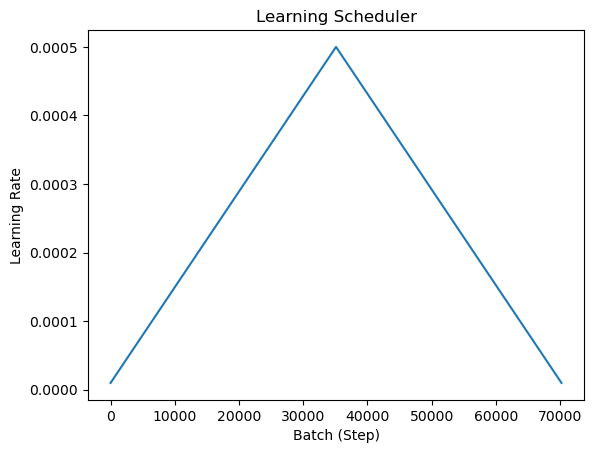

In [55]:
plot_lr_history()

Total epochs: 9
Min val_loss: 0.49982 at epoch 6



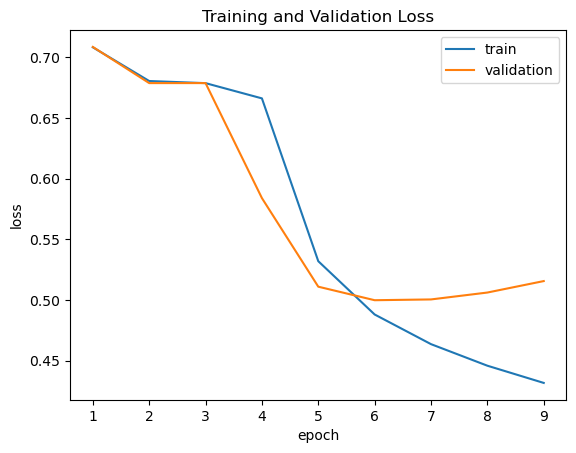

In [56]:
plot_train_history()

In [60]:
# user_id = df.user_id.sample(1).iloc[0]

# animes_watched_by_user = df[df.user_id == user_id]
# animes_not_watched = anime_df[
#     ~anime_df["MAL_ID"].isin(animes_watched_by_user.anime_id.values)
# ]["MAL_ID"]
# animes_not_watched = list(
#     set(animes_not_watched).intersection(set(anime_id_to_idx.keys()))
# )
# animes_not_watched = [[anime_id_to_idx.get(x)] for x in animes_not_watched]
# user_encoder = user_id_to_idx.get(user_id)
# user_anime_array = np.hstack(
#     ([[user_encoder]] * len(animes_not_watched), animes_not_watched)
# )
# ratings = model.predict(user_anime_array).flatten()
# top_ratings_indices = ratings.argsort()[-10:][::-1]

In [61]:
# user_idx, anime_idx
# user_anime_array[0][0]

In [62]:
# recommended_anime_ids = [
#     anime_idx_to_id.get(animes_not_watched[x][0]) for x in top_ratings_indices
# ]

# print("Showing recommendations for user: {}".format(user_id))
# print("====" * 9)
# print("Animes with high ratings from user")
# print("----" * 8)
# top_animes_user = (
#     animes_watched_by_user.sort_values(by="rating", ascending=False)
#     .head(5)
#     .anime_id.values
# )
# anime_df_rows = anime_df[anime_df["MAL_ID"].isin(top_animes_user)]
# display(anime_df_rows)
# # for row in anime_df_rows.itertuples():
# #     print(row.Name, ":", row.Genders)

# print("----" * 8)
# print("Top 10 anime recommendations")
# print("----" * 8)
# recommended_animes = anime_df[anime_df["MAL_ID"].isin(recommended_anime_ids)]
# display(recommended_animes)
# # for row in recommended_animes.itertuples():
# #     print(row.Name, ":", row.Genders)

# **Extracting weights from model**

In [57]:
WEIGHTS_PATH = 'weights.h5'
def load_trained_model():
    model = get_model()
    print('Calling model to load layers...')
    _ = model(tf.ones((1, 2)))
    model.load_weights(WEIGHTS_PATH)
    print('Loaded weights.')
    return model

In [58]:
%%time
model = load_trained_model()

[INFO] Using Subclassing API Model
Calling model to load layers...
Loaded weights.
CPU times: user 220 ms, sys: 378 ms, total: 598 ms
Wall time: 3.3 s


In [59]:
# load the best weights
try:
    if os.path.exists(checkpoint_filepath):
        model.load_weights(checkpoint_filepath)
except:
    print("[INFO] There is no checkpoint file")

In [60]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    # because Dot layer was using normalize=True..?
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [61]:
anime_weights.shape, user_weights.shape

((17562, 128), (145311, 128))

# Recommending Animes

In [62]:
anime_df = pd.read_csv('anime.csv')

In [63]:
anime_df.sort_values('Name', inplace=True)

In [64]:
all_anime_types = set(anime_df['Type'].unique())

def check_anime_types(types):
    types = set([types]) if isinstance(types, str) else set(types)
    if types.issubset(all_anime_types):
        return
    else:
        for anime_type in types:
            if anime_type not in all_anime_types:
                raise Exception(f'Anime type "{anime_type}" is not valid!')

def get_anime_rows(df, anime_query, exact_name=False, types=None):
    df = df.copy()
    if isinstance(anime_query, int):
        df = df[df.MAL_ID == anime_query]
    else:
        if exact_name:
            # get exact name
            df = df[df.Name == anime_query]
        else:
            df = df[df.Name.str.contains(anime_query, case=False, regex=False)]
        
    if types:
        check_anime_types(types)
        df = df[df.Type.isin(types)]
        
    return df

In [69]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def get_recommendation(anime_query, k=10, exact_name=False, types=None):
    if types:
        check_anime_types(types)
    anime_rows = get_anime_rows(anime_df, anime_query, 
                               exact_name=exact_name)
    if len(anime_rows) == 0:
        raise Exception(f'Anime not found for {anime_query}')
    anime_row = anime_rows.iloc[[0]]
    anime_id = anime_row.MAL_ID.values[0]
    anime_name = anime_row.Name.values[0]
    anime_idx = anime_id_to_idx.get(anime_id)

    weights = anime_weights
#         dists = np.dot(anime_weights[anime_idx], user_weights.T)
    distances = np.dot(weights, weights[anime_idx])

    sorted_dists_ind = np.argsort(distances)[::-1]

    print(f'Recommending animes for {anime_name}')
    display(anime_row.loc[:, 'MAL_ID': 'Aired'])

    anime_list = []
    # [1:] to skip the first row for anime_query
    for idx in sorted_dists_ind[1:]:
        similarity = distances[idx]
        anime_id = anime_idx_to_id.get(idx)
        anime_row = anime_df[anime_df.MAL_ID == anime_id]
        anime_type = anime_row.Type.values[0]
        if types and anime_type not in types:
            continue
        anime_name = anime_row.Name.values[0]
        score = anime_row.Score.values[0]
        genre = anime_row.Genres.values[0]

        anime_list.append({"Anime_id": anime_id, "Name": anime_name,
                           "Similarity": similarity, "Score": score,
                           "Type": anime_type, "Genre": genre
                          })
        if len(anime_list) == k:
            # enough number of recommendations
            break
    rec_df = pd.DataFrame(anime_list)
    return rec_df

In [70]:
get_recommendation('Dragon Ball Super', 10, types=('TV', 'Movie'))

Recommending animes for Dragon Ball Super


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired
10623,30694,Dragon Ball Super,7.42,"Action, Adventure, Comedy, Super Power, Martial Arts, Fantasy, Shounen",Dragon Ball Super,ドラゴンボール超（スーパー）,TV,131,"Jul 5, 2015 to Mar 25, 2018"


,Anime_id,Name,Similarity,Score,Type,Genre
0,22777,Dragon Ball Kai (2014),0.699218,7.69,TV,"Action, Adventure, Comedy, Super Power, Martial Arts, Fantasy, Shounen"
1,31722,Nanatsu no Taizai: Seisen no Shirushi,0.650817,7.12,TV,"Action, Adventure, Ecchi, Fantasy, Magic, Shounen, Supernatural"
2,34577,Nanatsu no Taizai: Imashime no Fukkatsu,0.646382,7.84,TV,"Action, Adventure, Fantasy, Magic, Shounen, Supernatural"
3,24703,High School DxD BorN,0.609331,7.45,TV,"Action, Comedy, Demons, Ecchi, Harem, Romance, School"
4,34281,High School DxD Hero,0.603054,7.28,TV,"Action, Comedy, Demons, Ecchi, Harem, Romance, School"
5,22043,Fairy Tail (2014),0.595496,7.73,TV,"Action, Adventure, Comedy, Fantasy, Magic, Shounen"
6,19157,Youkai Watch,0.590198,6.54,TV,"Comedy, Demons, Kids, Supernatural"
7,21639,Yu☆Gi☆Oh! Arc-V,0.589715,6.79,TV,"Action, Game, Fantasy, Shounen"
8,35964,Basilisk: Ouka Ninpouchou,0.586572,5.47,TV,"Action, Drama, Historical, Martial Arts"
9,33834,Sin: Nanatsu no Taizai,0.586406,5.69,TV,"Ecchi, Fantasy"


In [71]:
get_anime_rows(anime_df, 'kimi no na')

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
3850,4835,Bleach Movie 3: Fade to Black - Kimi no Na wo Yobu,7.52,"Action, Adventure, Comedy, Super Power, Supernatural, Shounen",Bleach the Movie:Fade to Black,劇場版 BLEACH Fade to Black 君の名を呼ぶ,Movie,1,"Dec 13, 2008",Unknown,...,12488.0,16473.0,28905.0,31320.0,13992.0,5920.0,1903.0,723.0,335.0,188.0
13149,35587,Boku wa Kimi no Namida,Unknown,"Music, Kids",Unknown,僕は君の涙,Music,1,"Jun 1, 1998",Unknown,...,12.0,2.0,10.0,18.0,22.0,19.0,5.0,3.0,Unknown,6.0
11308,32281,Kimi no Na wa.,8.96,"Romance, Supernatural, School, Drama",Your Name.,君の名は。,Movie,1,"Aug 26, 2016",Unknown,...,516874.0,333022.0,200239.0,86314.0,29641.0,12257.0,5199.0,2131.0,1116.0,3966.0
4249,5643,Kimi no Na wo Yobeba,6.39,"Hentai, School",Unknown,キミの名を呼べば,OVA,2,"Nov 28, 2008 to Feb 27, 2009",Unknown,...,101.0,110.0,240.0,336.0,278.0,184.0,87.0,54.0,36.0,43.0


In [73]:
get_recommendation('Naruto', 10)

Recommending animes for Boruto: Naruto Next Generations


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired
12492,34566,Boruto: Naruto Next Generations,5.81,"Action, Adventure, Super Power, Martial Arts, Shounen",Boruto:Naruto Next Generations,BORUTO -NARUTO NEXT GENERATIONS-,TV,Unknown,"Apr 5, 2017 to ?"


,Anime_id,Name,Similarity,Score,Type,Genre
0,34572,Black Clover,0.868225,7.38,TV,"Action, Comedy, Magic, Fantasy, Shounen"
1,37885,Super Dragon Ball Heroes,0.766834,5.29,ONA,"Action, Comedy, Super Power, Martial Arts, Fantasy, Shounen"
2,41074,Digimon Adventure:,0.730358,6.77,TV,"Action, Adventure, Comedy, Fantasy, Kids"
3,36029,Hakyuu Houshin Engi,0.694058,5.41,TV,"Adventure, Demons, Fantasy, Shounen, Supernatural"
4,40145,Yu☆Gi☆Oh!: Sevens,0.692118,5.4,TV,"Action, Game, Fantasy, Shounen"
5,37140,Gegege no Kitarou (2018),0.686610,7.23,TV,"Comedy, Demons, Supernatural, Shounen"
6,44208,Yami Shibai 8,0.681168,6.09,TV,"Dementia, Horror, Supernatural"
7,39551,Tensei shitara Slime Datta Ken 2nd Season,0.679556,8.06,TV,"Comedy, Fantasy"
8,40852,Dr. Stone: Stone Wars,0.672524,8.29,TV,"Sci-Fi, Adventure, Shounen"
9,36516,Beatless,0.669299,6.2,TV,"Action, Drama, Romance, Sci-Fi"


In [48]:
get_recommendation('Sword Art Online', 10)

Recommending animes for Sword Art Online


,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired
6614,11757,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online,ソードアート・オンライン,TV,25,"Jul 8, 2012 to Dec 23, 2012"


,Anime_id,Name,Similarity,Score,Type,Genre
0,21881,Sword Art Online II,0.856271,6.79,TV,"Action, Game, Adventure, Romance, Fantasy"
1,19815,No Game No Life,0.764166,8.2,TV,"Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy"
2,16498,Shingeki no Kyojin,0.717274,8.48,TV,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
3,22319,Tokyo Ghoul,0.691462,7.81,TV,"Action, Mystery, Horror, Psychological, Supernatural, Drama, Seinen"
4,28121,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka,0.688285,7.64,TV,"Action, Adventure, Comedy, Romance, Fantasy"
5,22199,Akame ga Kill!,0.668604,7.53,TV,"Action, Adventure, Drama, Fantasy, Shounen"
6,20021,Sword Art Online: Extra Edition,0.667963,6.61,Special,"Action, Adventure, Fantasy, Game, Romance"
7,10620,Mirai Nikki,0.639832,7.54,TV,"Action, Mystery, Psychological, Shounen, Supernatural, Thriller"
8,11617,High School DxD,0.635851,7.4,TV,"Comedy, Demons, Ecchi, Harem, Romance, School"
9,6547,Angel Beats!,0.632495,8.15,TV,"Action, Comedy, Drama, School, Supernatural"


In [205]:
get_recommendation('Black Clover', 10)

Recommending animes for Black Clover


,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired
12493,34572,Black Clover,7.38,"Action, Comedy, Magic, Fantasy, Shounen",Black Clover,ブラッククローバー,TV,170,"Oct 3, 2017 to Mar 30, 2021"


,Anime_id,Name,Similarity,Score,Type,Genre
0,34566,Boruto: Naruto Next Generations,0.696372,5.81,TV,"Action, Adventure, Super Power, Martial Arts, Shounen"
1,40748,Jujutsu Kaisen (TV),0.588791,8.54,TV,"Action, Demons, Supernatural, School, Shounen"
2,37885,Super Dragon Ball Heroes,0.542996,5.29,ONA,"Action, Comedy, Super Power, Martial Arts, Fantasy, Shounen"
3,41074,Digimon Adventure:,0.509338,6.77,TV,"Action, Adventure, Comedy, Fantasy, Kids"
4,32772,Puzzle & Dragons Cross,0.482487,6.48,TV,"Game, Kids"
5,36934,Captain Tsubasa (2018),0.460898,7.42,TV,"Action, Sports, Shounen"
6,36516,Beatless,0.460792,6.2,TV,"Action, Drama, Romance, Sci-Fi"
7,37202,Radiant,0.455345,6.87,TV,"Action, Adventure, Fantasy, Magic"
8,37447,Karakuri Circus (TV),0.451193,7.09,TV,"Action, Adventure, Mystery, Drama, Shounen"
9,37430,Tensei shitara Slime Datta Ken,0.450611,8.07,TV,"Fantasy, Shounen"
